# Fitting with ChiSquare, Binned Likelihood, and Unbinned Likelihood

This is an introduction to likelihood fits, both binned and unbinned, trying to show the following points:
1. How likelihood fits work, both binned and unbinned.
2. When to use which type of fits, also including ChiSquare.
3. See how the amount of statistics influences the above choice.

Comparisons are naturally done with the ChiSquare. Also, this program serves as an introduction to fitting with iMinuit.

The exercise is made to play around with the (statistics of) the signal and background distributions, so that you can get a feel for the advantages and drawbacks of each method... and make sure that you feel comfortable in applying all three.

### References:
- Barlow: 5.3 + 5.4 + 5.6
- Bevington: Chapter 10

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 23-11-2022 (latest update)

***

In [24]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats, optimize

In [25]:
sys.path.append('../../External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax   # Useful functions to print fit results on figure

Below are some of the general program settings, which are good to have in one place:

In [26]:
r = np.random # Random generator
r.seed(42)    # Set a random seed (but a fixed one)

save_plots = False # For now, don't save plots (once you trust your code, switch on)
verbose = True     # For now, print a lot of output (once you trust your code, switch off)
Nverbose = 10      # But only print a lot for the first 10 random numbers

## Truth values used:

We choose some "god given" values (the "truth") to simulate the data with. The goal of the fits is to estimate these values most accurately, as if you had data, and wanted to extract these values from it.

In [27]:
# Signal parameters:
Npeak = 100           # Number of random Gaussian points
mu_peak = 3.0        # Peak location
sigma_peak = 0.3     # Peak width

# Background parameters:
Nbkg  = 40     # Number of random Exponential points
tau_bkg = 3.0        # Decay constant (could be anything!)

## Create the data:

We create some data with a signal peak on an exponential background:

In [28]:
# Create signal:
x_peak = r.normal(loc=mu_peak, scale=sigma_peak, size=Npeak)

# Create background:
x_bkg  = r.exponential(tau_bkg, Nbkg)

# Combine the two:
x_all = np.concatenate((x_peak, x_bkg), axis=0)
if (verbose) :
    print(x_all)

[ 3.14901425  2.95852071  3.19430656  3.45690896  2.92975399  2.92975891
  3.47376384  3.23023042  2.85915768  3.16276801  2.86097469  2.86028107
  3.07258868  2.42601593  2.48252465  2.83131374  2.69615066  3.0942742
  2.72759278  2.57630889  3.43969463  2.93226711  3.02025846  2.57257554
  2.83668518  3.03327678  2.65470193  3.11270941  2.81980839  2.91249188
  2.81948802  3.55568346  2.99595083  2.68268672  3.24676347  2.63374691
  3.06265908  2.41209896  2.60154419  3.05905837  3.22153997  3.05141048
  2.96530552  2.90966889  2.5564434   2.78404674  2.86180837  3.31713667
  3.10308549  2.47108795  3.09722519  2.88447532  2.7969234   3.18350289
  3.30929986  3.27938404  2.74823474  2.90723629  3.09937903  3.29266354
  2.85624773  2.94430231  2.66809951  2.64113801  3.24375775  3.40687201
  2.97839696  3.30105987  3.10849081  2.80646407  3.10841868  3.46141097
  2.98925219  3.4693931   2.21407647  3.24657075  3.02611412  2.91029779
  3.02752823  2.40372933  2.93409843  3.10713377  3.

## Histogram of data:

Since we are considering both ChiSquare (chi2) and Binned Likelihood (bllh), we start with the histogram, which is the input for both of these. Of course, the Unbinned Likelihood (ullh) doesn't care about binning!

### Note on binning:
It is very important to specify - in a well thought manner - the range and binning to use. Many problems could have been avoided by a few minutes (or even seconds!) of consideration from the beginning. 

In [29]:
# General input:
Nbins = 100
xmin, xmax = 0, 10
binwidth = (xmax-xmin)/Nbins

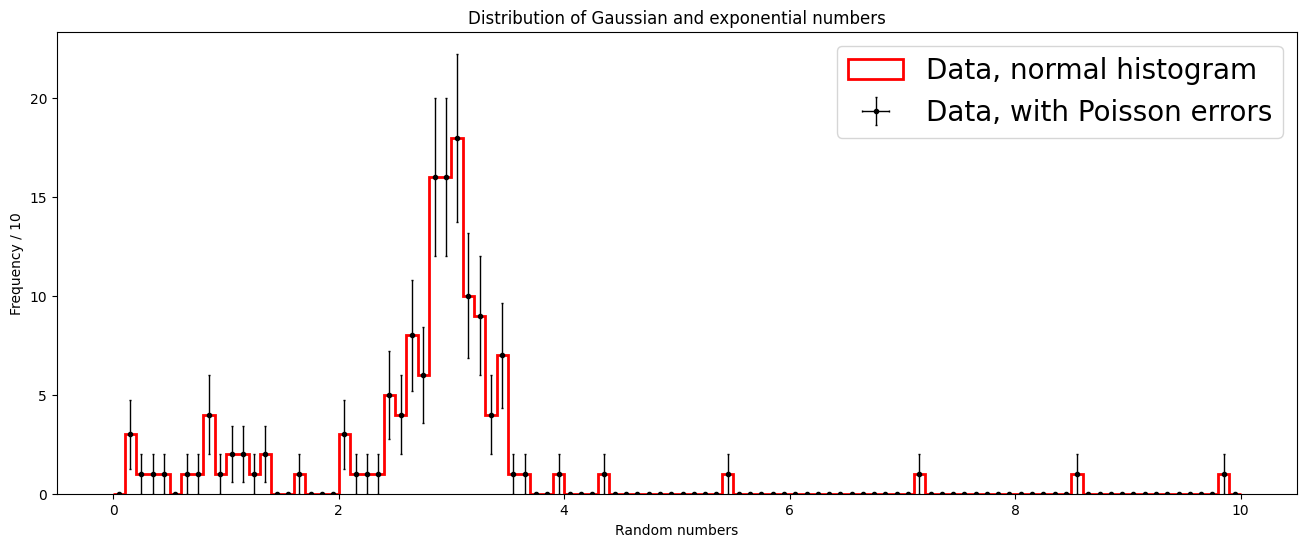

In [30]:
# Create just a single figure and axes, and a (classic) histogram:
fig, ax = plt.subplots(figsize=(16, 6))
hist = ax.hist(x_all, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, color='red', label='Data, normal histogram')

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(x_all, bins=Nbins, range=(xmin, xmax))
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)   # NOTE: We (naturally) assume that the bin count is Poisson distributed.
                       # This is an approximation, since there is a low count in the last bins.


# Did you make sure, that all bins were non-zero???
# x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
# y = counts[counts>0]
# sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.

# Now create a histogram with uncertainties (better, I would argue):
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="Random numbers",           # the label of the y axis
       ylabel="Frequency / 10",           # the label of the y axis
       title ="Distribution of Gaussian and exponential numbers")    # the title of the plot
ax.legend(loc='best', fontsize=20);       # could also be # loc = 'upper right' e.g.

## Fit to the data / histogram (1D):

Having created the data, we now want to fit the distributions in three ways:
1. ChiSquare fit
2. Binned Likelihood fit
3. Unbinned Likelihood fit

We first define the function to be fitted with, a Gaussian and and Exponential PDF in this case:

In [31]:
# Define background PDF:
def exp_pdf(x, tau):
    """Exponential with lifetime tau"""
    return 1.0 / tau * np.exp(-x/tau)

In [32]:
# Define signal PDF:
def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    return 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

In [33]:
# Define your actual fitting function, with both background and signal in:
# which is NOT normalised but has normalisation constants "N" in, and includes the bin width:
def fit_pdf(x, Nexp, tau, Ngauss, mu, sigma) :
    """Exponential + Gaussian"""
    return Nexp * binwidth * exp_pdf(x, tau) + Ngauss * binwidth * gauss_pdf(x, mu, sigma)

In [34]:
# Define your actual fitting function, with both background and signal in,
# which is NOT normalised but has normalisation constants "N" in, but does NOT includes the bin width:
def fit_pdf_llhfit(x, Nexp, tau, Ngauss, mu, sigma) :
    """Exponential + Gaussian"""
    return Nexp * exp_pdf(x, tau) + Ngauss * gauss_pdf(x, mu, sigma)

Having defined our fitting function, we now want to make our three types of fits. Make sure that you understand the difference between the three.

It is important to use the same bins and bounds as the original histogram. In this case we are also treating the number of events/random numbers as being a fit variable.

***

# ChiSquare fit:

### Setting up a fit:

We initialize our fitting object, `chi2fit`, by using the `Chi2Regression` function from External Functions. You can also define your own Chi2 function (see introduction to plotting and fitting in Week0 and below). This first takes the function to fit as input, then the input data.
Following this, we make a Minuit object, i.e. the minimisation itself. This is done using __[iMinuit](https://iminuit.readthedocs.io/en/latest/)__ which is a Python-wrapper for the wonderful minimization tool Minuit developed by CERN. Minuit requires the fitting object (here "chi2fit") and then GOOD input values and fitting options. Finally, we ask Minuit to actually find the minimum, and we have added a check to see, if this converged or not.

In [35]:
Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)

# Defining Chi2 calculation:
def chi2_owncalc(Nexp, tau, Ngauss, mu, sigma) :
    y_fit = fit_pdf(x[counts > 0], Nexp, tau, Ngauss, mu, sigma)
    chi2 = np.sum(((y[counts > 0] - y_fit) / sy[counts > 0])**2)
    return chi2

# Alternatively, use the Chi2 regression from External Functions:
chi2fit = Chi2Regression(fit_pdf, x[counts > 0], y[counts > 0], sy[counts > 0])

# NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

minuit_chi2 = Minuit(chi2_owncalc, Nexp=Nbkg, tau=2.9, Ngauss=Npeak, mu=3.1, sigma=0.3)
minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
minuit_chi2.migrad();           # This is where the minimisation is carried out! Put ";" at the end to void output

#### Extracting fit results - values and $\chi^2$:

Once the fit has converged, the results and $\chi^2$ probability should be evaluated.

In [36]:
# First, check if the result was a valid minimum:
if (not minuit_chi2.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    
    
# Short hand way of accessing the fit parameters:
fit_Ngauss, fit_mu, fit_sigma, fit_Nexp, fit_tau = minuit_chi2.values[:]   # The fitted values of the parameters

# Loop to get both parameter values and uncertainties:
for name in minuit_chi2.parameters :
    value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
    print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

# Get Chi2 value:
chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

# Get number of degrees-of-freedom (Ndof):
N_NotEmptyBin = np.sum(y > 0)
Ndof_value = N_NotEmptyBin - minuit_chi2.nfit

Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
#print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.3f}")

Fit value: Nexp = 305.51942 +/- 511.15727
Fit value: tau = 23.28374 +/- 42.98049
Fit value: Ngauss = 80.80740 +/- 10.28542
Fit value: mu = 2.98239 +/- 0.02992
Fit value: sigma = 0.22343 +/- 0.02911


#### Drawing fit result on top of data:

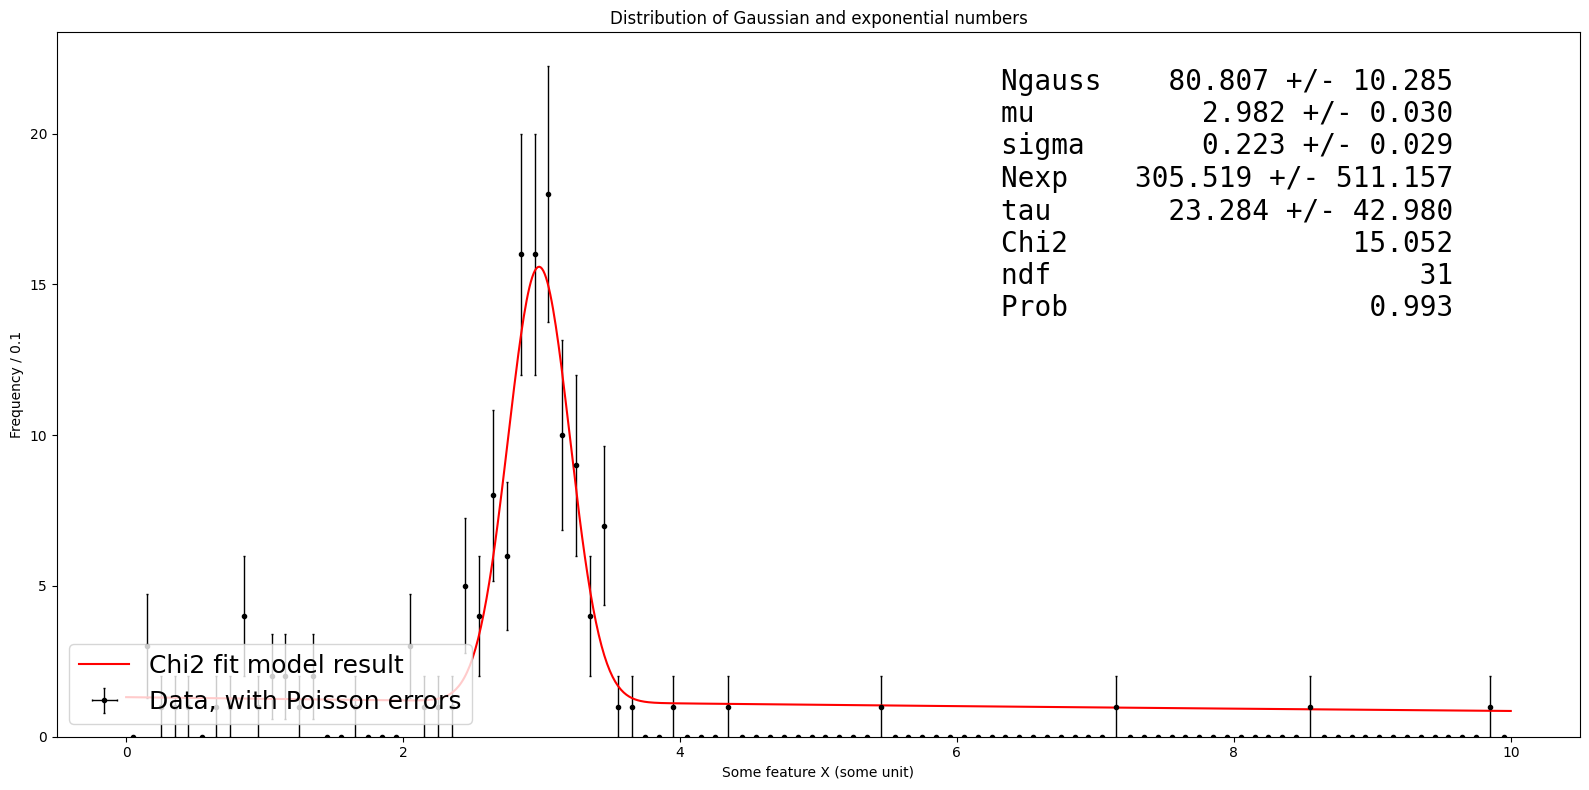

In [37]:
# Create just a single figure and axes, along with a histogram with uncertainties:
fig, ax = plt.subplots(figsize=(16, 8))  # figsize is in inches
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="Some feature X (some unit)", # the label of the y axis
       ylabel="Frequency / 0.1",  # the label of the y axis
       title="Distribution of Gaussian and exponential numbers", # the title of the plot
       ylim=[0.0,None]) # Setting the miminum to zero

# Adding fit function to plot:
x_axis = np.linspace(xmin, xmax, 1000)
ax.plot(x_axis, fit_pdf(x_axis, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result') 

# Adding fit results to plot:
d = {'Ngauss':   [minuit_chi2.values['Ngauss'], minuit_chi2.errors['Ngauss']],
     'mu':       [minuit_chi2.values['mu'], minuit_chi2.errors['mu']],
     'sigma':       [minuit_chi2.values['sigma'], minuit_chi2.errors['sigma']],
     'Nexp':     [minuit_chi2.values['Nexp'], minuit_chi2.errors['Nexp']],
     'tau':         [minuit_chi2.values['tau'], minuit_chi2.errors['tau']],
     'Chi2':     chi2_value,
     'ndf':      Ndof_value,
     'Prob':     Prob_value,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.62, 0.95, text, ax, fontsize=20)
ax.legend(loc='lower left', fontsize=18); # could also be # loc = 'upper right' e.g.
fig.tight_layout()

# Binned Likelihood fit:

Next we try to fit the same data with the same function in a *binned likelihood fit*. Note that the fitting object now takes the x-values themselves (not a histogram), but requires numbers of bins and a range/bound.

In [38]:
bllhfit = BinnedLH(fit_pdf_llhfit, x_all, bins=Nbins, bound=(xmin, xmax), extended=True)
minuit_bllh = Minuit(bllhfit, Nexp=Nbkg, tau=2.9, Ngauss=Npeak, mu=3.1, sigma=0.3)
minuit_bllh.errordef = 0.5     # Value for likelihood fits
minuit_bllh.migrad()           # Perform the actual fit

c:\Users\Simon\PycharmProjects\Projects\Projects\AppStat2022\Week2\FittingMethods\../../External_Functions\ExternalFunctions.py:277: UserWarning: x is really small return 0
  warnings.warn('x is really small return 0')


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 33.53                      │              Nfcn = 117              │
│ EDM = 1.51e-06 (Goal: 0.0001)    │            time = 1.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Nexp   │    38     │     7     │            │            │         │         │       │
│ 1 │ tau    │    2.4    │    0.5    │            │            │         │         │       │
│ 2 │ Ngauss │    100    │    10     │            │            │         │         │       │
│ 3 │ mu     │   2.976   │   0.030   │            │            │         │         │       │
│ 4 │ sigma  │   0.271   │   0.025   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────┐
│        │      Nexp       tau    Ngauss        mu     sigma │
├────────┼───────────────────────────────────────────────────┤
│   Nexp │      50.3     0.458     -10.9    0.0145   -0.0348 │
│    tau │     0.458     0.216     -0.23 -0.000241 -0.000552 │
│ Ngauss │     -10.9     -0.23       111   -0.0145    0.0337 │
│     mu │    0.0145 -0.000241   -0.0145  0.000912 -9.82e-05 │
│  sigma │   -0.0348 -0.000552    0.0337 -9.82e-05   0.00062 │
└────────┴───────────────────────────────────────────────────┘

# Unbinned Likelihood fit:

For the *unbinned likelihood fit*, the input is again the x-values themselves, and bounds are possible, but no binning is suggested, as this is... well... unbinned.

In [39]:
ullhfit = UnbinnedLH(fit_pdf_llhfit, x_all, bound=(xmin, xmax), extended=True)
minuit_ullh = Minuit(ullhfit, Nexp=Nbkg, tau=2.9, Ngauss=Npeak, mu=3.1, sigma=0.3)
minuit_ullh.errordef = 0.5     # Value for likelihood fits
minuit_ullh.migrad()           # Perform the actual fit
print(minuit_ullh.fval)

-408.4081845499725


For Chi2:
Nexp =  305.51942312196996  ±  511.15726916329737
tau =  23.28373651411651  ±  42.980485514791084
Ngauss =  80.80739627589766  ±  10.285419983895206
mu =  2.9823912590858117  ±  0.02991788445372661
sigma =  0.22342553643308566  ±  0.02911053801461481
For Binned LH:
Nexp =  38.24617143580458  ±  7.095471292650728
tau =  2.390084436207928  ±  0.4651386551621974
Ngauss =  100.3530967273413  ±  10.527405121761166
mu =  2.975819512576467  ±  0.030202960456833964
sigma =  0.27089315188064234  ±  0.024905390332748193
For Unbinned LH:
Nexp =  40.643261362106955  ±  7.524175699350477
tau =  2.2561228817102723  ±  0.4316820709910587
Ngauss =  99.86003115217927  ±  10.560025478399963
mu =  2.976074020014675  ±  0.030411652282690015
sigma =  0.2703255237555902  ±  0.025676955354318697


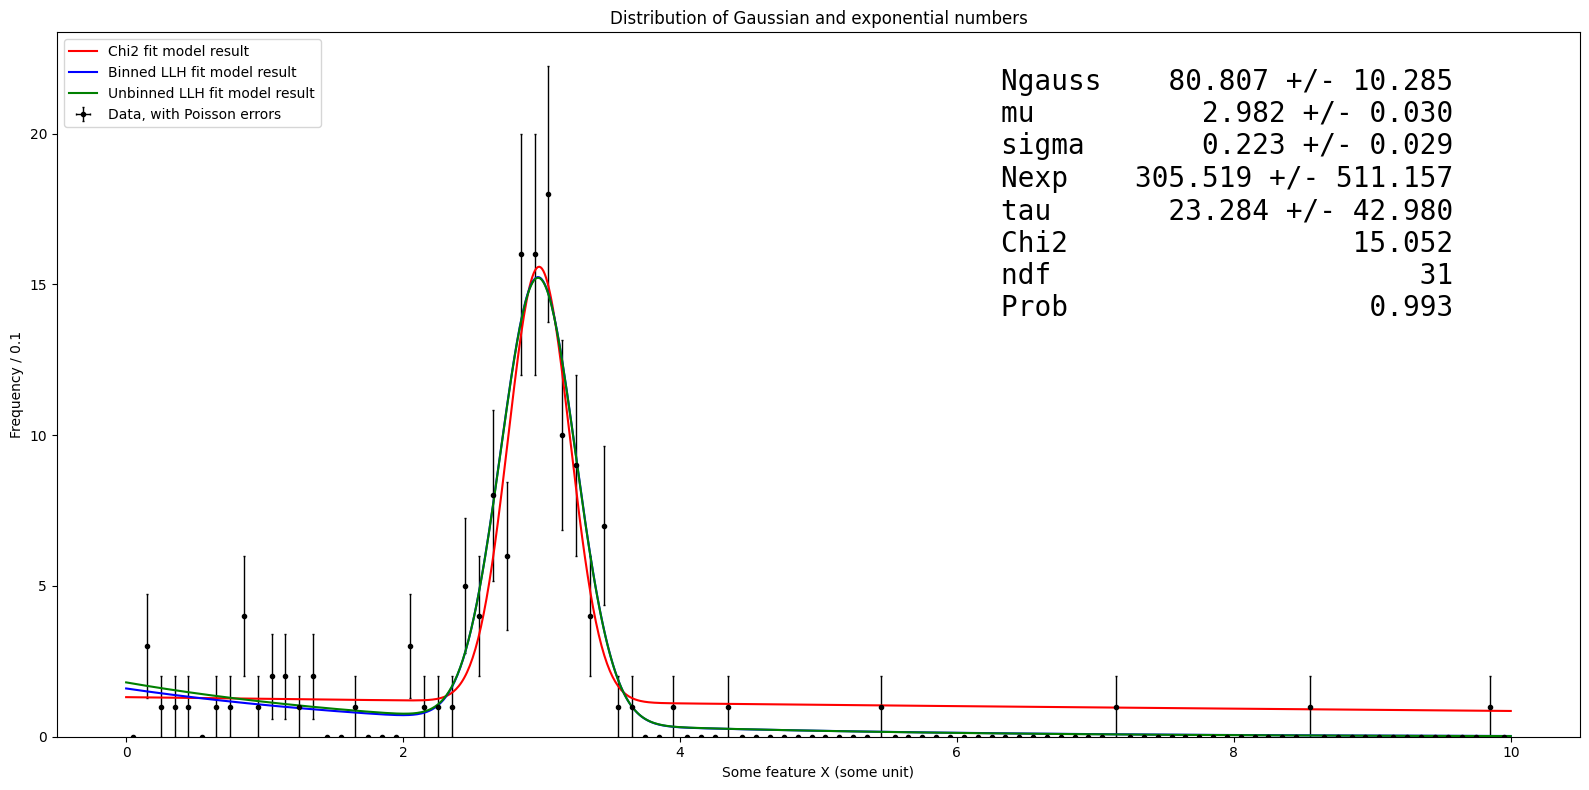

In [40]:
if (not minuit_bllh.fmin.is_valid) :
    print("  WARNING: The Binned Likelihood fit DID NOT converge!!! ")    

if (not minuit_ullh.fmin.is_valid) :
    print("  WARNING: The Unbinned Likelihood fit DID NOT converge!!! ")

# Notice how both results are plotted with the "usual" PDF, as the fit parameters should be correct/similar. 
ax.plot(x_axis, fit_pdf(x_axis, *minuit_bllh.values[:]), '-b', label='Binned LLH fit model result') 
ax.plot(x_axis, fit_pdf(x_axis, *minuit_ullh.values[:]), '-g', label='Unbinned LLH fit model result') 
ax.legend(loc = 'upper left')



param_values = [minuit_chi2.values[:], minuit_bllh.values[:], minuit_ullh.values[:]]
param_errors =  [minuit_chi2.errors[:], minuit_bllh.errors[:], minuit_ullh.errors[:]]
names = ['Chi2', 'Binned LH', 'Unbinned LH']
param_names = ['Nexp', 'tau', 'Ngauss', 'mu', 'sigma']
for i, (val, err) in enumerate(zip(param_values, param_errors)):
    print(f'For {names[i]}:')
    for j, name in enumerate(param_names):
        print(f'{name} = ', val[j], " \u00B1 ", err[j])

fig

In [49]:
def rejection_sampling_uniform(function, fmax, bounds, Npoints, verbose = True):

    ## ALGORITHM: The goal is to x1, ...., xn points distributed according to f on domain D
    # 1) generate a point x in D distributed according to a probability distribution g/area(g) (so g can be any curve...) enclosing f, ie f <= g on D
    # 2) generate uniformly a random point u in [0,g(x)]
    # 3) if u<f(x), keep x. 
    # 4) Rinse and repeat until desired number of points has been aquired

    # generate values according to f using rejection samping
    r = np.random
   # r.seed(123456789)

    xmin, xmax = bounds[0], bounds[1] 

    ## Using rejection/accepting method with both a constant pdf as well as 1/(1+x)
    x_accepted = np.empty(0)
    N_try = int(3 * Npoints)
    N_accum = 0
  
    while x_accepted.size < Npoints:
        # Construct N_points points by accepting/rejecting using a uniform pdf
        ## First, we construct N_try points uniformly on [xmin,xmax]
        r_vals = xmin + (xmax - xmin) * r.rand(N_try)
        ## Next, we construct another set of uniform random values in [0,fmax = y]
        #u_vals = fmax * r.rand(N_try)
        u_vals = r.uniform(0, fmax, size = N_try)
        ## Finally, we keep only the r_vals values satisfying u_vals < f(r_vals)
        mask = (u_vals < function(r_vals))
        vals = function(r_vals)

        x_accepted = np.r_['0', x_accepted, r_vals[mask]]

        # store total number of calculated samples
        N_accum += N_try
        # update N_try
        N_try = int(3 * (Npoints - x_accepted.size))

        if x_accepted.size > Npoints:
            x_accepted = x_accepted[:Npoints]

    eff_uni = Npoints / N_accum
    eff_err = np.sqrt(eff_uni*(1-eff_uni) / N_accum)
 
    if verbose:
        print("efficiency uniform: ", f'{eff_uni:6.3f}', "\u00B1 ", f'{eff_err:6.3f}')

    return x_accepted, eff_uni, eff_err


def evaluate_likelihood_fit (fit_function, fmax, parameter_val_arr, log_likelihood_val, bounds, Ndatapoints, Nsimulations, Nbins = 0, unbinned = True):
    """
    fit_function is assumed to have the form f(x, *parameters), with x taking values in bounds
    """
    LL_values = np.empty(Nsimulations)
    Nsucceses = 0
    max_iterations = 2 * Nsimulations
    iterations = 0
   
     # Simulate data
    while Nsucceses < Nsimulations and iterations < max_iterations:
        iterations += 1

        # Create values distributed according to fit_function
        x_vals, _, _ = rejection_sampling_uniform(lambda x: fit_function(x, *parameter_val_arr), fmax, bounds = bounds, Npoints = Ndatapoints, verbose = False)
    
        # Construct fitting object
        if unbinned:
            LLH_object = UnbinnedLH(fit_function, x_vals, bound = (bounds[0], bounds[1]), extended = True)
            fit = Minuit(LLH_object, *parameter_val_arr)
        else:
            LLH_object =  BinnedLH(fit_function, x_vals, bins = Nbins, bound = (bounds[0], bounds[1]), extended = True)
            fit = Minuit(LLH_object, *parameter_val_arr)

        fit.errordef = Minuit.LIKELIHOOD
        fit.migrad()

        if fit.fmin.is_valid:
            LL_values[Nsucceses] = fit.fval
            Nsucceses += 1
        else:
            print(f"ERROR: Fit did not converge for simulation no. {Nsucceses}. Log likelihood value is not collected.")

    mask = (LL_values > log_likelihood_val)
    p_value = len(LL_values[mask]) / Nsimulations

    return LL_values, p_value

efficiency uniform:   0.093 ±   0.002
[40.643261362106955, 2.2561228817102723, 99.86003115217927, 2.976074020014675, 0.2703255237555902] -408.4081845499725 152.18547184445006


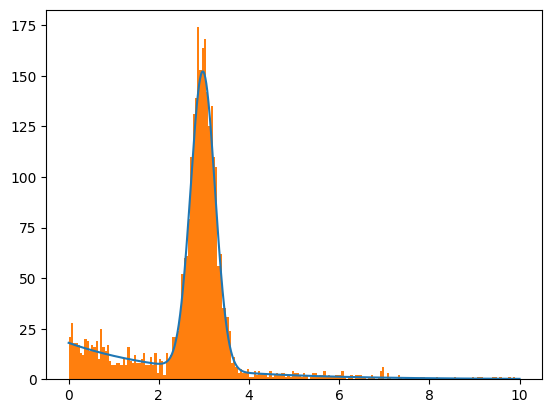

In [42]:
#find max value of f
x_vals = np.linspace(0,10,1000)
fmax = np.max(fit_pdf_llhfit(x_vals, *minuit_ullh.values[:]))
plt.plot(x_vals, fit_pdf_llhfit(x_vals, *minuit_ullh.values[:]))

x_acc, _,_ = rejection_sampling_uniform(lambda x: fit_pdf_llhfit(x, *minuit_ullh.values[:]), fmax, bounds = (xmin,xmax), Npoints = 3000, verbose = True)

plt.hist(x_acc, bins = 2*Nbins, range = (xmin, xmax));
print(minuit_ullh.values[:], minuit_ullh.fval, fmax)

100 40
unbinned p-value:  0.31


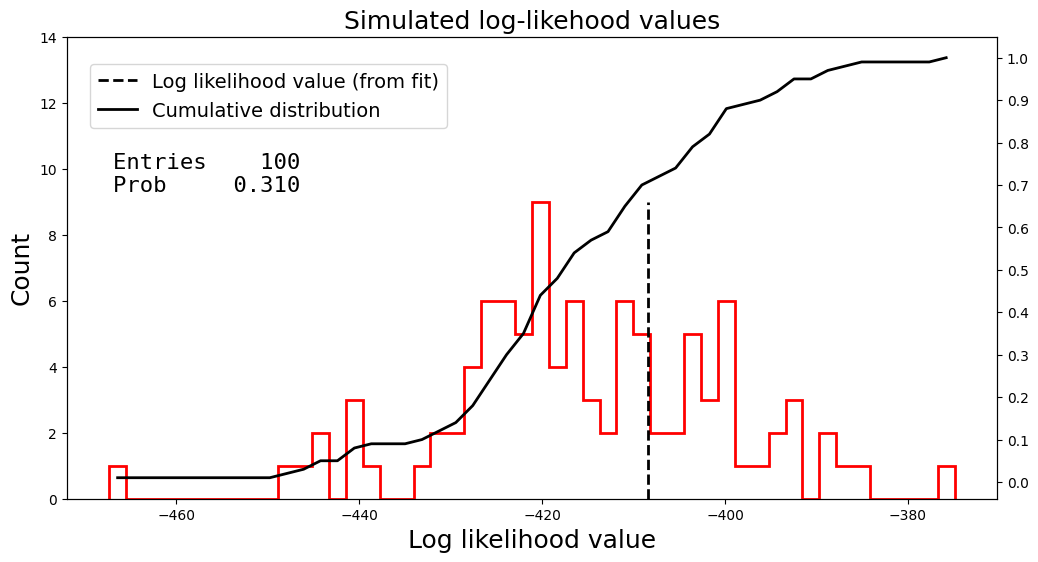

In [50]:

Nsimulations = 100

ULL_values, p_val_u = evaluate_likelihood_fit(fit_pdf_llhfit, fmax, minuit_ullh.values[:], minuit_ullh.fval, bounds = (xmin, xmax), Ndatapoints = (Npeak + Nbkg), \
    Nsimulations = Nsimulations, Nbins = 0, unbinned = True)

print("unbinned p-value: ", p_val_u)

fig0, ax0 = plt.subplots(figsize = (12,6))
ax0.set_xlabel('Log likelihood value', fontsize = 18)
ax0.set_ylabel('Count', fontsize = 18)
ax0.set_title('Simulated log-likehood values', fontsize = 18)

counts, edges, _ = plt.hist(ULL_values, bins = 50, histtype = 'step', lw = 2, color = 'red');
x_vals = 0.5 * (edges[:-1] + edges[1:])
ax0.set_ylim(0,np.max(counts+5))
ax0.plot([minuit_ullh.fval,minuit_ullh.fval], [0,np.max(counts)], 'k--', label = 'Log likelihood value (from fit)', lw = 2)

ax00 = ax0.twinx()
ax00.set_yticks(np.arange(0,1.1, 0.1))
val_cumsum = np.cumsum(counts) / counts.sum()

ax00.plot(x_vals, val_cumsum, 'k-', label = 'Cumulative distribution', lw = 2)
# Adding fit results to plot:
d = {'Entries':   Nsimulations,
     'Prob':     p_val_u}

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.05, 0.75, text, ax0, fontsize=16)
#ax00.legend(loc='best', fontsize=16); # could also be # loc = 'upper right' e.g.
#ax00.legend(loc = 'best', fontsize = 16)
fig0.legend( fontsize = 14, bbox_to_anchor = (0.25,0.65,0.2,0.2))
fig.tight_layout()

In [44]:
if 0:
    BLL_values, p_val_B = evaluate_likelihood_fit(fit_pdf_llhfit, fmax, minuit_bllh.values[:], minuit_bllh.fval, bounds = (xmin, xmax), Ndatapoints = (Npeak + Nbkg), \
        Nsimulations = 200, Nbins = Nbins, unbinned = False)

    print("binned p-value: ", p_val_B)

    counts, _, _ = plt.hist(BLL_values, bins = 50, histtype = 'step');
    plt.plot([minuit_bllh.fval,minuit_bllh.fval], [0,np.max(counts)], 'k--', label = 'Log likelihood value' )
    plt.legend()

# Questions:

This exercise is meant for you to see to what extend the three fitting methods give the same results when varying the input parameters, especially when the number of signal and background events is low, and also when the binning is (too) coarse.

1) Start by drawing all three fits on top of the data. Do they (by eye) give the same result, and does the fit generally look "good"? How do you judge that? Also, compare the fitted values of the three fits, and see if they agree within uncertainties?

2) Now repeat question 1) for lower statistics cases, for example Ngauss = 20 and Nexp = 50. See to what extend the different methods yields reasonable results (i.e. in accordance with the input values). You will encounter problems to be mended by yourself, such as empty bins (should not be passed to the ChiSquare dividing by "observed events", but is fine for the LLH fits) and poor initial values.
Possibly also alter the number of bins to 50 or 25 - is that a good choice? Why/why not?

---

### Advanced question:

3) Knowing the PDFs used for producing the data, try to see, if you can produce a goodness-of-fit measure for the unbinned likelihood fit by repeating this type of fit many times on (re-)simulated data.

4) Improve on the printing of results on the plots to better align and have a choice of decimals :-)

# Learning points:

The exercise is meant as an illustration of the three main fitting paradigms:
1. ChiSquare (binned)
2. Likelihood (binned)
3. Likelihood (unbinned)

While the ChiSquare is almost always recommendable to start out with, low statistics makes it non-optimal. If possible, use an unbinned likelihood, and if the data is already binned, use a binned likelihood.